$\Large\color{blue}{\text{PyGMTSAR Sentinel-1 SLC Timeseries Analysis 2 Scenes 6 Subswaths 15m}}$

$\Large\color{blue}{\text{This notebook is optimized to work in Docker container (Ubuntu 22.04 Jammy) 16 GB RAM 1 GB swap 4 cores}}$

### PyGMTSAR is my free-time Open Source project.

That's a bit curious how the project was started a year ago. I develop geophysical inversion methods and processing software for many years using my fundamental physics and mathematics background. Satellite interferometry is the key point to validate my inversion models and I found the same problem as you too that the existing interferometry packages usage is a pain. There is no interactive processing with multiprocessing and even a progressbar and ability to view and change every step code and validate the results. Also, many used algorithms are too outdated and produce terrible results like to tension surfaces in GMT which is used widely in GMTSAR (hmm, how about to control a smothness of derivative? Tension surfaces were invented when all the Earths computers where less powerfull than your smarthone today. If you are interested I shared the examples in GMTSAR bug tracker). Anyway, I found GMT mathematics is really crazy and the developers replace one incorrect algorithm by another and back often as we see in the codes and the changelog). That was enough reason to check all the used algorithms and replace these by modern and correct ones. By this way, I use only GMTSAR C codes with my patches to fix some errors and allow interoperability with Python wrappers plus my own codes around them. GMTSAR codes are fine and without crazy GMT codes work better and the processing is much faster. Alright, I spent one month to make the initial PyGMTSAR realization and it works. Recently, I returned to the project to add some more sophisticated features like to scenes and subswathes stitching. I'm going to share some of my geological exprorations and seismic models as live examples on Google Colab as soon as it will be possible to do. How lineaments and ore zones are related to interferograms? How gas and oil deposits are related to surface movements on interferometry displacement maps? I have the answer and I work on the tools to model and visualize them.

You'd find my theoretical models and processing codes foir geophisical inversions in Github repository https://github.com/mobigroup/gis-snippets and tools for the 4D results vizualization in https://github.com/mobigroup/ParaView-plugins

Ah yes, a little bit about me. I have STEM master's degree in radio physics and in 2004 I was awarded first prize of the All-Russian Physics competition for significant results in Inverse modeling for non-linear optics and holography, also applicable for Inverse Modeling of Gravity, Magnetic, and Thermal fields. In addition to my fundamental science knowledge, I’m world class data scientist and software developer with 20 years experience in science and industrial development. I have worked on government contracts and universities projects and on projects for LG Corp, Google Inc, etc. You are able to find some of my software and results on LinkedIn and GitHub and Upwork. By the way, I left Russia many years ago and I work remotely for about 20 years.

### To order some research, development and support see my profile on freelance platform [Upwork](https://www.upwork.com/freelancers/~01e65e8e7221758623)

### @ Alexey Pechnikov, August, 2022

[Geological models on YouTube channel](https://www.youtube.com/channel/UCSEeXKAn9f_bDiTjT6l87Lg)

[Augmented Reality (AR) Geological Models](https://mobigroup.github.io/ParaView-Blender-AR/)

[GitHub repositories](https://github.com/mobigroup)

[English posts and articles on LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/)

[Russian articles on Habr](https://habr.com/ru/users/N-Cube/posts/)

## Load Modules to Check Environment

In [1]:
import platform, sys, os

## Load and Setup Python Modules

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
# supress numpy warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# plotting modules
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import holoviews as hv
pd.options.plotting.backend = 'hvplot'
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [4]:
# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Load Custom Python Modules

In [5]:
# default chunksize (512) is enough suitable for a single subswath processing using resolution 15m
# select higher chunk size (1024) to process multiple subswaths and scenes using resolution 15m
from pygmtsar import datagrid
datagrid.chunksize = 1024

In [6]:
# import the top level class only
from pygmtsar import SBAS

## Define 3 Sentinel-1 Scenes and Processing Parameters

In [7]:
ORBIT     = 'D'
SUBSWATH  = 123
# common configuration
DATADIR      = 'data_asc' if ORBIT == 'A' else 'data_desc'
#BACKUP       = 'backup_asc' if ORBIT == 'A' else 'backup_desc'
BACKUP       = None
WORKDIR      = 'raw_asc' if ORBIT == 'A' else 'raw_desc'
DEMFILE      = None
POLARIZATION = 'VV'
# SBAS parameters
BASEDAYS     = 65
BASEMETERS   = 150
RESOLUTION   = 15

### Reuse Backup Dataset If Exists

Use backup/restore feature for reproducible runs when the original large dataset cropped to the minimal one to save disk space significantly.

In [8]:
if BACKUP is not None and os.path.isdir(BACKUP):
    print ('Found backup dataset, use it instead of the cold run')
    DATADIR      = BACKUP
    DEMFILE      = f'{BACKUP}/DEM_WGS84.nc'

## Run Local Dask Cluster

Launch Dask cluster for big data processing. Use "Dashboard" link below for the local cluster state and execution monitoring.

In [9]:
import dask, dask.distributed
# increase timeouts to work using default chunk size (512) even on large areas
dask.config.set({'distributed.comm.timeouts.tcp': '60s'})
#print (dask.config.get("distributed.comm.timeouts.tcp"))
dask.config.set({'distributed.comm.timeouts.connect': '60s'})
#print (dask.config.get("distributed.comm.timeouts.connect"))

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:32845' processes=1 threads=4, memory=15.61 GiB>

## Init SBAS

In [10]:
sbas = SBAS(DATADIR, DEMFILE, basedir=WORKDIR,
    filter_orbit=ORBIT,
    filter_subswath=SUBSWATH,
    filter_polarization=POLARIZATION)

NOTE: Found multiple scenes for a single day, use function SBAS.reframe() to stitch the scenes
NOTE: Please follow all the notes listed above


In [11]:
sbas.to_dataframe()

datetime orbit mission polarization  subswath  \
date                                                                  
2022-01-09 2022-01-09 02:52:57     D     S1A           VV         1   
2022-01-09 2022-01-09 02:53:22     D     S1A           VV         1   
2022-01-09 2022-01-09 02:52:55     D     S1A           VV         2   
2022-01-09 2022-01-09 02:53:20     D     S1A           VV         2   
2022-01-09 2022-01-09 02:52:56     D     S1A           VV         3   
2022-01-09 2022-01-09 02:53:21     D     S1A           VV         3   
2022-01-21 2022-01-21 02:52:56     D     S1A           VV         1   
2022-01-21 2022-01-21 02:53:21     D     S1A           VV         1   
2022-01-21 2022-01-21 02:52:54     D     S1A           VV         2   
2022-01-21 2022-01-21 02:53:19     D     S1A           VV         2   
2022-01-21 2022-01-21 02:52:55     D     S1A           VV         3   
2022-01-21 2022-01-21 02:53:20     D     S1A           VV         3   
2022-02-02 2022-02-02 02:52:56     D     S1A           VV         1   
2022-02-02 2022-02-02 02:53:20     D     S1A           VV         1   
2022-02-02 2022-02-02 02:52:54     D     S1A           VV         2   
2022-02-02 2022-02-02 02:53:19     D     S1A           VV         2   
2022-02-02 2022-02-02 02:52:55     D     S1A           VV         3   
2022-02-02 2022-02-02 02:53:20     D     S1A           VV         3   
2022-02-14 2022-02-14 02:52:56     D     S1A           VV         1   
2022-02-14 2022-02-14 02:53:20     D     S1A           VV         1   
2022-02-14 2022-02-14 02:52:54     D     S1A           VV         2   
2022-02-14 2022-02-14 02:53:19     D     S1A           VV         2   
2022-02-14 2022-02-14 02:52:55     D     S1A           VV         3   
2022-02-14 2022-02-14 02:53:20     D     S1A           VV         3   
2022-02-26 2022-02-26 02:52:56     D     S1A           VV         1   
2022-02-26 2022-02-26 02:53:20     D     S1A           VV         1   
2022-02-26 2022-02-26 02:52:54     D     S1A           VV         2   
2022-02-26 2022-02-26 02:53:19     D     S1A           VV         2   
2022-02-26 2022-02-26 02:52:55     D     S1A           VV         3   
2022-02-26 2022-02-26 02:53:19     D     S1A           VV         3   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         1   
2022-03-10 2022-03-10 02:53:20     D     S1A           VV         1   
2022-03-10 2022-03-10 02:52:54     D     S1A           VV         2   
2022-03-10 2022-03-10 02:53:18     D     S1A           VV         2   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         3   
2022-03-10 2022-03-10 02:53:19     D     S1A           VV         3   
2022-03-22 2022-03-22 02:52:56     D     S1A           VV         1   
2022-03-22 2022-03-22 02:53:21     D     S1A           VV         1   
2022-03-22 2022-03-22 02:52:54     D     S1A           VV         2   
2022-03-22 2022-03-22 02:53:19     D     S1A           VV         2   
2022-03-22 2022-03-22 02:52:55     D     S1A           VV         3   
2022-03-22 2022-03-22 02:53:20     D     S1A           VV         3   

                                                                                               datapath  \
date                                                                                                      
2022-01-09  data_desc/measurement/s1a-iw1-slc-vv-20220109t025257-20220109t025322-041378-04eb6a-004.tiff   
2022-01-09  data_desc/measurement/s1a-iw1-slc-vv-20220109t025322-20220109t025347-041378-04eb6a-004.tiff   
2022-01-09  data_desc/measurement/s1a-iw2-slc-vv-20220109t025255-20220109t025320-041378-04eb6a-005.tiff   
2022-01-09  data_desc/measurement/s1a-iw2-slc-vv-20220109t025320-20220109t025348-041378-04eb6a-005.tiff   
2022-01-09  data_desc/measurement/s1a-iw3-slc-vv-20220109t025256-20220109t025321-041378-04eb6a-006.tiff   
2022-01-09  data_desc/measurement/s1a-iw3-slc-vv-20220109t025321-20220109t025346-041378-04eb6a-006.tiff   
2022-01-21  data_desc/measurement/s1a-iw1

### Download Sentinel-1 Orbits

In [15]:
# also, we can place pre-downloaded orbit files to data directory 
sbas.download_orbits()

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

In [16]:
sbas.to_dataframe()

datetime orbit mission polarization  subswath  \
date                                                                  
2022-01-09 2022-01-09 02:52:57     D     S1A           VV         1   
2022-01-09 2022-01-09 02:53:22     D     S1A           VV         1   
2022-01-09 2022-01-09 02:52:55     D     S1A           VV         2   
2022-01-09 2022-01-09 02:53:20     D     S1A           VV         2   
2022-01-09 2022-01-09 02:52:56     D     S1A           VV         3   
2022-01-09 2022-01-09 02:53:21     D     S1A           VV         3   
2022-01-21 2022-01-21 02:52:56     D     S1A           VV         1   
2022-01-21 2022-01-21 02:53:21     D     S1A           VV         1   
2022-01-21 2022-01-21 02:52:54     D     S1A           VV         2   
2022-01-21 2022-01-21 02:53:19     D     S1A           VV         2   
2022-01-21 2022-01-21 02:52:55     D     S1A           VV         3   
2022-01-21 2022-01-21 02:53:20     D     S1A           VV         3   
2022-02-02 2022-02-02 02:52:56     D     S1A           VV         1   
2022-02-02 2022-02-02 02:53:20     D     S1A           VV         1   
2022-02-02 2022-02-02 02:52:54     D     S1A           VV         2   
2022-02-02 2022-02-02 02:53:19     D     S1A           VV         2   
2022-02-02 2022-02-02 02:52:55     D     S1A           VV         3   
2022-02-02 2022-02-02 02:53:20     D     S1A           VV         3   
2022-02-14 2022-02-14 02:52:56     D     S1A           VV         1   
2022-02-14 2022-02-14 02:53:20     D     S1A           VV         1   
2022-02-14 2022-02-14 02:52:54     D     S1A           VV         2   
2022-02-14 2022-02-14 02:53:19     D     S1A           VV         2   
2022-02-14 2022-02-14 02:52:55     D     S1A           VV         3   
2022-02-14 2022-02-14 02:53:20     D     S1A           VV         3   
2022-02-26 2022-02-26 02:52:56     D     S1A           VV         1   
2022-02-26 2022-02-26 02:53:20     D     S1A           VV         1   
2022-02-26 2022-02-26 02:52:54     D     S1A           VV         2   
2022-02-26 2022-02-26 02:53:19     D     S1A           VV         2   
2022-02-26 2022-02-26 02:52:55     D     S1A           VV         3   
2022-02-26 2022-02-26 02:53:19     D     S1A           VV         3   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         1   
2022-03-10 2022-03-10 02:53:20     D     S1A           VV         1   
2022-03-10 2022-03-10 02:52:54     D     S1A           VV         2   
2022-03-10 2022-03-10 02:53:18     D     S1A           VV         2   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         3   
2022-03-10 2022-03-10 02:53:19     D     S1A           VV         3   
2022-03-22 2022-03-22 02:52:56     D     S1A           VV         1   
2022-03-22 2022-03-22 02:53:21     D     S1A           VV         1   
2022-03-22 2022-03-22 02:52:54     D     S1A           VV         2   
2022-03-22 2022-03-22 02:53:19     D     S1A           VV         2   
2022-03-22 2022-03-22 02:52:55     D     S1A           VV         3   
2022-03-22 2022-03-22 02:53:20     D     S1A           VV         3   

                                                                                               datapath  \
date                                                                                                      
2022-01-09  data_desc/measurement/s1a-iw1-slc-vv-20220109t025257-20220109t025322-041378-04eb6a-004.tiff   
2022-01-09  data_desc/measurement/s1a-iw1-slc-vv-20220109t025322-20220109t025347-041378-04eb6a-004.tiff   
2022-01-09  data_desc/measurement/s1a-iw2-slc-vv-20220109t025255-20220109t025320-041378-04eb6a-005.tiff   
2022-01-09  data_desc/measurement/s1a-iw2-slc-vv-20220109t025320-20220109t025348-041378-04eb6a-005.tiff   
2022-01-09  data_desc/measurement/s1a-iw3-slc-vv-20220109t025256-20220109t025321-041378-04eb6a-006.tiff   
2022-01-09  data_desc/measurement/s1a-iw3-slc-vv-20220109t025321-20220109t025346-041378-04eb6a-006.tiff   
2022-01-21  data_desc/measurement/s1a-iw1

## Reframe Scenes (Optional)

### Define Pair of Pins for Each Subswath (Optional)

BACKUP directory stores already cropped scenes so miss the pinning to prevent useless reframing

In [17]:
#if DATADIR != BACKUP and ORBIT == 'D':
#    sbas.set_pins([48.5, 37.8, 48.5, 38.1], [47.5, 38, 47.5, 38.3])

In [18]:
# for the full scenes
sbas.set_pins()

NOTE subswath 1: pin1 is not defined, master image corner coordinate will be used
NOTE subswath 1: pin2 is not defined, master image corner coordinate will be used
NOTE subswath 2: pin1 is not defined, master image corner coordinate will be used
NOTE subswath 2: pin2 is not defined, master image corner coordinate will be used
NOTE subswath 3: pin1 is not defined, master image corner coordinate will be used
NOTE subswath 3: pin2 is not defined, master image corner coordinate will be used


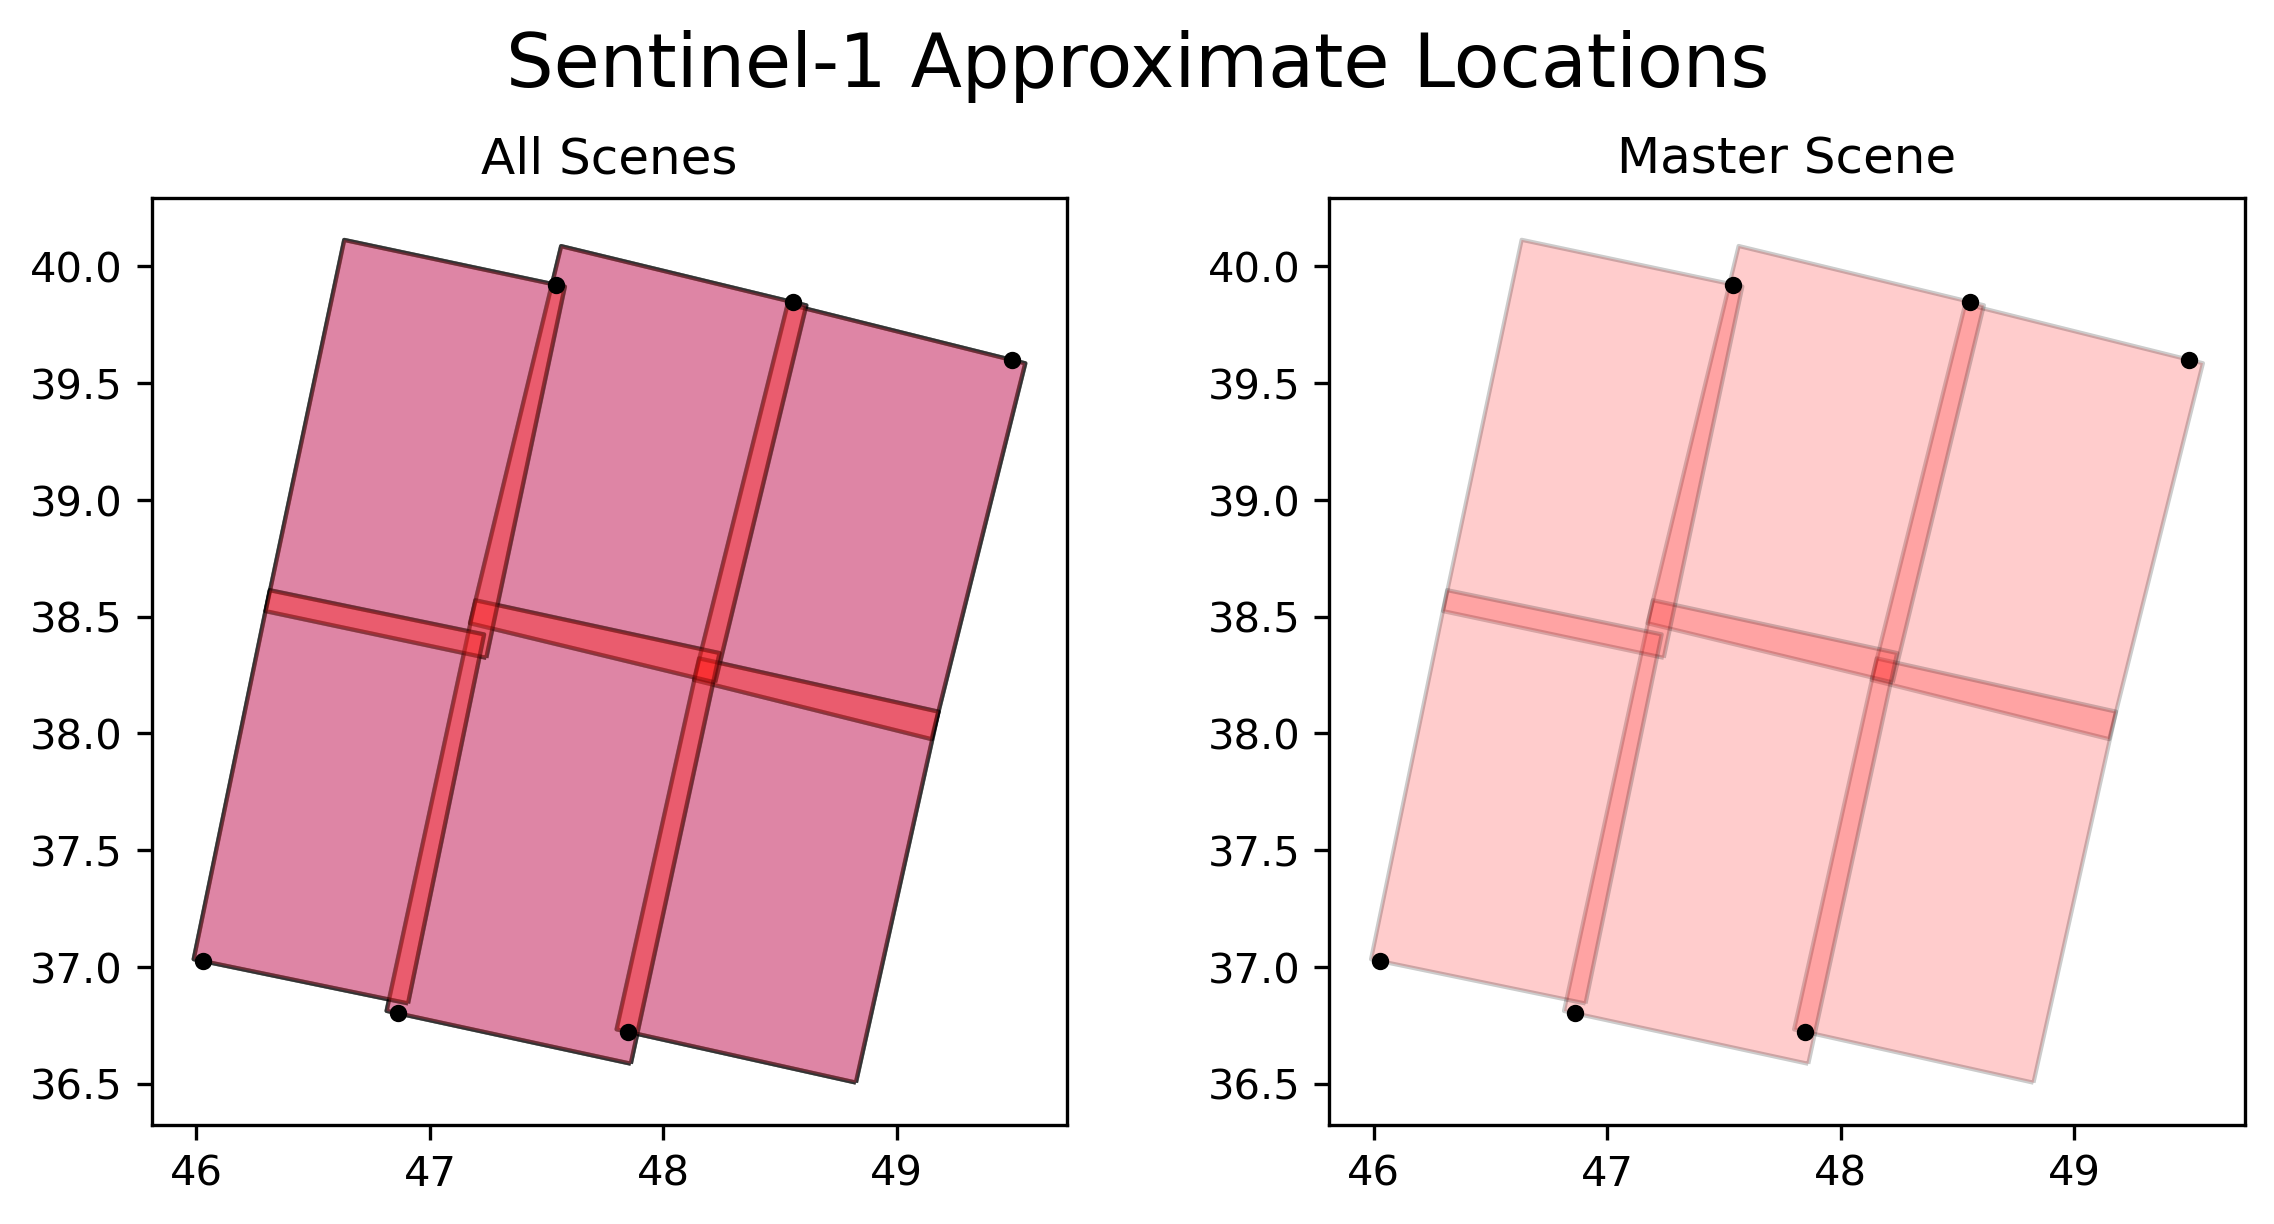

In [19]:
fig = plt.figure(figsize=(8,4), dpi=300)

#ax = fig.add_subplot(1, subswaths, subswath + 1)
#topo_ra[subswath][::4,::4].plot.imshow(cmap='gray', vmin=0, ax=ax)
#plt.xlabel('Range', fontsize=16)
#plt.ylabel('Azimuth', fontsize=16)
#plt.title('Subswath', fontsize=18)

ax = fig.add_subplot(1, 2, 1)
gdf = sbas.to_dataframe()
cmap = plt.cm.get_cmap('bwr', len(gdf.index.unique()))
colors = dict([(v,cmap(k)) for k,v in enumerate(gdf.index.unique())])
gdf.reset_index().plot(color=[colors[k] for k in gdf.index], alpha=0.2, edgecolor='black', ax=ax)
ax.scatter(x=sbas.get_pins()[::2], y=sbas.get_pins()[1::2], color='black', s=10)
ax.set_title('All Scenes', fontsize=12)

ax = fig.add_subplot(1, 2, 2)
gdf = sbas.get_master()
cmap = plt.cm.get_cmap('bwr', len(gdf.index.unique()))
colors = dict([(v,cmap(k)) for k,v in enumerate(gdf.index.unique())])
gdf.reset_index().plot(color=[colors[k] for k in gdf.index], alpha=0.2, edgecolor='black', ax=ax)
ax.scatter(x=sbas.get_pins()[::2], y=sbas.get_pins()[1::2], color='black', s=10)
ax.set_title('Master Scene', fontsize=12)

plt.suptitle('Sentinel-1 Approximate Locations', fontsize=18)
plt.tight_layout()
plt.show()

### Crop the Frame (Optional)

In [20]:
sbas.reframe_parallel()

Reframing:   0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
sbas.to_dataframe()

datetime orbit mission polarization  subswath  \
date                                                                  
2022-01-09 2022-01-09 02:52:57     D     S1A           VV         1   
2022-01-09 2022-01-09 02:52:55     D     S1A           VV         2   
2022-01-09 2022-01-09 02:52:56     D     S1A           VV         3   
2022-01-21 2022-01-21 02:52:56     D     S1A           VV         1   
2022-01-21 2022-01-21 02:52:54     D     S1A           VV         2   
2022-01-21 2022-01-21 02:52:55     D     S1A           VV         3   
2022-02-02 2022-02-02 02:52:56     D     S1A           VV         1   
2022-02-02 2022-02-02 02:52:54     D     S1A           VV         2   
2022-02-02 2022-02-02 02:52:55     D     S1A           VV         3   
2022-02-14 2022-02-14 02:52:56     D     S1A           VV         1   
2022-02-14 2022-02-14 02:52:54     D     S1A           VV         2   
2022-02-14 2022-02-14 02:52:55     D     S1A           VV         3   
2022-02-26 2022-02-26 02:52:56     D     S1A           VV         1   
2022-02-26 2022-02-26 02:52:54     D     S1A           VV         2   
2022-02-26 2022-02-26 02:52:55     D     S1A           VV         3   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         1   
2022-03-10 2022-03-10 02:52:54     D     S1A           VV         2   
2022-03-10 2022-03-10 02:52:55     D     S1A           VV         3   
2022-03-22 2022-03-22 02:52:56     D     S1A           VV         1   
2022-03-22 2022-03-22 02:52:54     D     S1A           VV         2   
2022-03-22 2022-03-22 02:52:55     D     S1A           VV         3   

                                                                                  datapath  \
date                                                                                         
2022-01-09  raw_desc/s1a-iw1-slc-vv-20220109t025257-20220109t025347-041378-04eb6a-004.tiff   
2022-01-09  raw_desc/s1a-iw2-slc-vv-20220109t025255-20220109t025348-041378-04eb6a-005.tiff   
2022-01-09  raw_desc/s1a-iw3-slc-vv-20220109t025256-20220109t025346-041378-04eb6a-006.tiff   
2022-01-21  raw_desc/s1a-iw1-slc-vv-20220121t025256-20220121t025346-041553-04f124-004.tiff   
2022-01-21  raw_desc/s1a-iw2-slc-vv-20220121t025254-20220121t025347-041553-04f124-005.tiff   
2022-01-21  raw_desc/s1a-iw3-slc-vv-20220121t025255-20220121t025345-041553-04f124-006.tiff   
2022-02-02  raw_desc/s1a-iw1-slc-vv-20220202t025256-20220202t025346-041728-04f723-004.tiff   
2022-02-02  raw_desc/s1a-iw2-slc-vv-20220202t025254-20220202t025346-041728-04f723-005.tiff   
2022-02-02  raw_desc/s1a-iw3-slc-vv-20220202t025255-20220202t025345-041728-04f723-006.tiff   
2022-02-14  raw_desc/s1a-iw1-slc-vv-20220214t025256-20220214t025346-041903-04fd3e-004.tiff   
2022-02-14  raw_desc/s1a-iw2-slc-vv-20220214t025254-20220214t025347-041903-04fd3e-005.tiff   
2022-02-14  raw_desc/s1a-iw3-slc-vv-20220214t025255-20220214t025345-041903-04fd3e-006.tiff   
2022-02-26  raw_desc/s1a-iw1-slc-vv-20220226t025256-20220226t025345-042078-050346-004.tiff   
2022-02-26  raw_desc/s1a-iw2-slc-vv-20220226t025254-20220226t025346-042078-050346-005.tiff   
2022-02-26  raw_desc/s1a-iw3-slc-vv-20220226t025255-20220226t025345-042078-050346-006.tiff   
2022-03-10  raw_desc/s1a-iw1-slc-vv-20220310t025255-20220310t025345-042253-050934-004.tiff   
2022-03-10  raw_desc/s1a-iw2-slc-vv-20220310t025254-20220310t025346-042253-050934-005.tiff   
2022-03-10  raw_desc/s1a-iw3-slc-vv-20220310t025255-20220310t025345-042253-050934-006.tiff   
2022-03-22  raw_desc/s1a-iw1-slc-vv-20220322t025256-20220322t025346-042428-050f2a-004.tiff   
2022-03-22  raw_desc/s1a-iw2-slc-vv-20220322t025254-20220322t025347-042428-050f2a-005.tiff   
2022-03-22  raw_desc/s1a-iw3-slc-vv-20220322t025255-20220322t025345-042428-050f2a-006.tiff   

                                                                                 metapath  \
date                                                                                        
2022-01-09  raw_desc/s1a-iw1-slc-vv-202

### Download SRTM DEM

The DEM resolution is equal to the output geocoded resolution so select it carefully. Usually 60 meters resolution is enough. For fast check use 90 or 120 meters resolution. Internal processing resolution is about 15m and it can be decimated using post-processing function on interferogram processing step.

In [22]:
sbas.download_dem(backend='GMT', resolution_meters=RESOLUTION)

DEM Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
dem = sbas.get_dem().coarsen({'lon': 32, 'lat': 32}, boundary='trim').mean()
dem

<xarray.DataArray 'z' (lat: 825, lon: 813)>
dask.array<mean_agg-aggregate, shape=(825, 813), dtype=float32, chunksize=(32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 45.96 45.96 45.97 45.97 ... 49.55 49.56 49.56 49.57
  * lat      (lat) float64 36.47 36.47 36.48 36.48 ... 40.12 40.12 40.13 40.13
Attributes:
    long_name:     z
    actual_range:  [-896.28863525 4816.16259766]

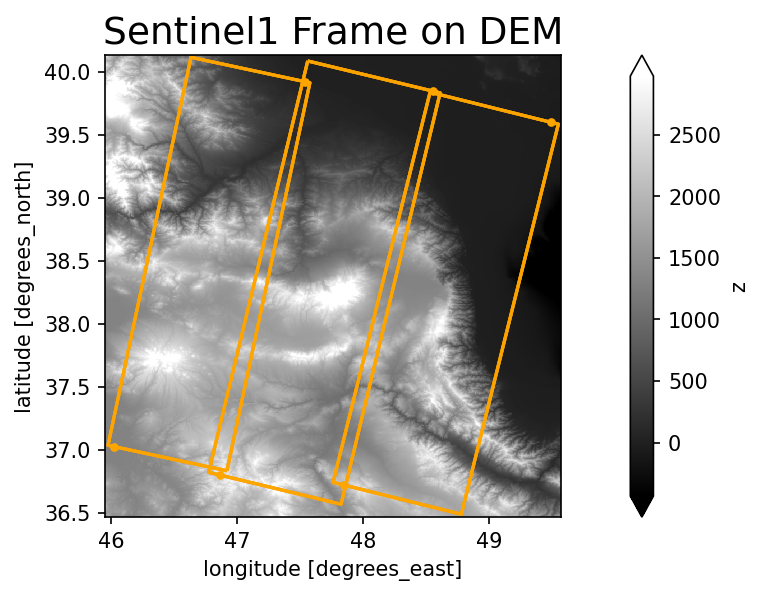

In [24]:
plt.figure(figsize=(12,4), dpi=150)
zmin, zmax = np.nanquantile(dem, [0.01, 0.99])
dem.plot.imshow(cmap='gray', vmin=zmin, vmax=zmax)
sbas.to_dataframe()['geometry'].apply(lambda geom: geom.boundary).plot(color='orange', alpha=0.5, ax=plt.gca())
plt.scatter(x=sbas.get_pins()[::2], y=sbas.get_pins()[1::2], color='orange', s=10)
plt.title('Sentinel1 Frame on DEM', fontsize=18)
plt.show()

## Select Master Image Using SBAS Baseline

In [30]:
baseline_pairs = sbas.baseline_pairs(days=BASEDAYS, meters=BASEMETERS)
print (f'Found SBAS pairs: {len(baseline_pairs)}')

PRM generation:   0%|          | 0/7 [00:00<?, ?it/s]

Found SBAS pairs: 20


In [32]:
baseline_pairs

ref_date    rep_date  ref_timeline  ref_baseline  rep_timeline  \
0   2022-01-09  2022-01-21       2022.02         -0.00       2022.05   
1   2022-01-09  2022-02-02       2022.02         -0.00       2022.08   
2   2022-01-09  2022-02-14       2022.02         -0.00       2022.11   
3   2022-01-09  2022-02-26       2022.02         -0.00       2022.15   
4   2022-01-09  2022-03-10       2022.02         -0.00       2022.18   
5   2022-01-21  2022-02-02       2022.05         38.23       2022.08   
6   2022-01-21  2022-02-14       2022.05         38.23       2022.11   
7   2022-01-21  2022-02-26       2022.05         38.23       2022.15   
8   2022-01-21  2022-03-10       2022.05         38.23       2022.18   
9   2022-01-21  2022-03-22       2022.05         38.23       2022.21   
10  2022-02-02  2022-02-14       2022.08         16.21       2022.11   
11  2022-02-02  2022-02-26       2022.08         16.21       2022.15   
12  2022-02-02  2022-03-10       2022.08         16.21       2022.18   
13  2022-02-02  2022-03-22       2022.08         16.21       2022.21   
14  2022-02-14  2022-02-26       2022.11         33.87       2022.15   
15  2022-02-14  2022-03-10       2022.11         33.87       2022.18   
16  2022-02-14  2022-03-22       2022.11         33.87       2022.21   
17  2022-02-26  2022-03-10       2022.15          2.93       2022.18   
18  2022-02-26  2022-03-22       2022.15          2.93       2022.21   
19  2022-03-10  2022-03-22       2022.18        -80.17       2022.21   

    rep_baseline  
0          38.23  
1          16.21  
2          33.87  
3           2.93  
4         -80.17  
5          16.21  
6          33.87  
7           2.93  
8         -80.17  
9          25.81  
10         33.87  
11          2.93  
12        -80.17  
13         25.81  
14          2.93  
15        -80.17  
16         25.81  
17        -80.17  
18         25.81  
19         25.81

In [33]:
median_baseline = baseline_pairs['ref_baseline'].median()
median_baseline

16.21

In [34]:
idx = abs(baseline_pairs['ref_baseline'] - median_baseline).idxmin()
master = baseline_pairs.iloc[idx]['ref_date']
master

'2022-02-02'

In [35]:
# set master image
sbas = sbas.set_master(master)

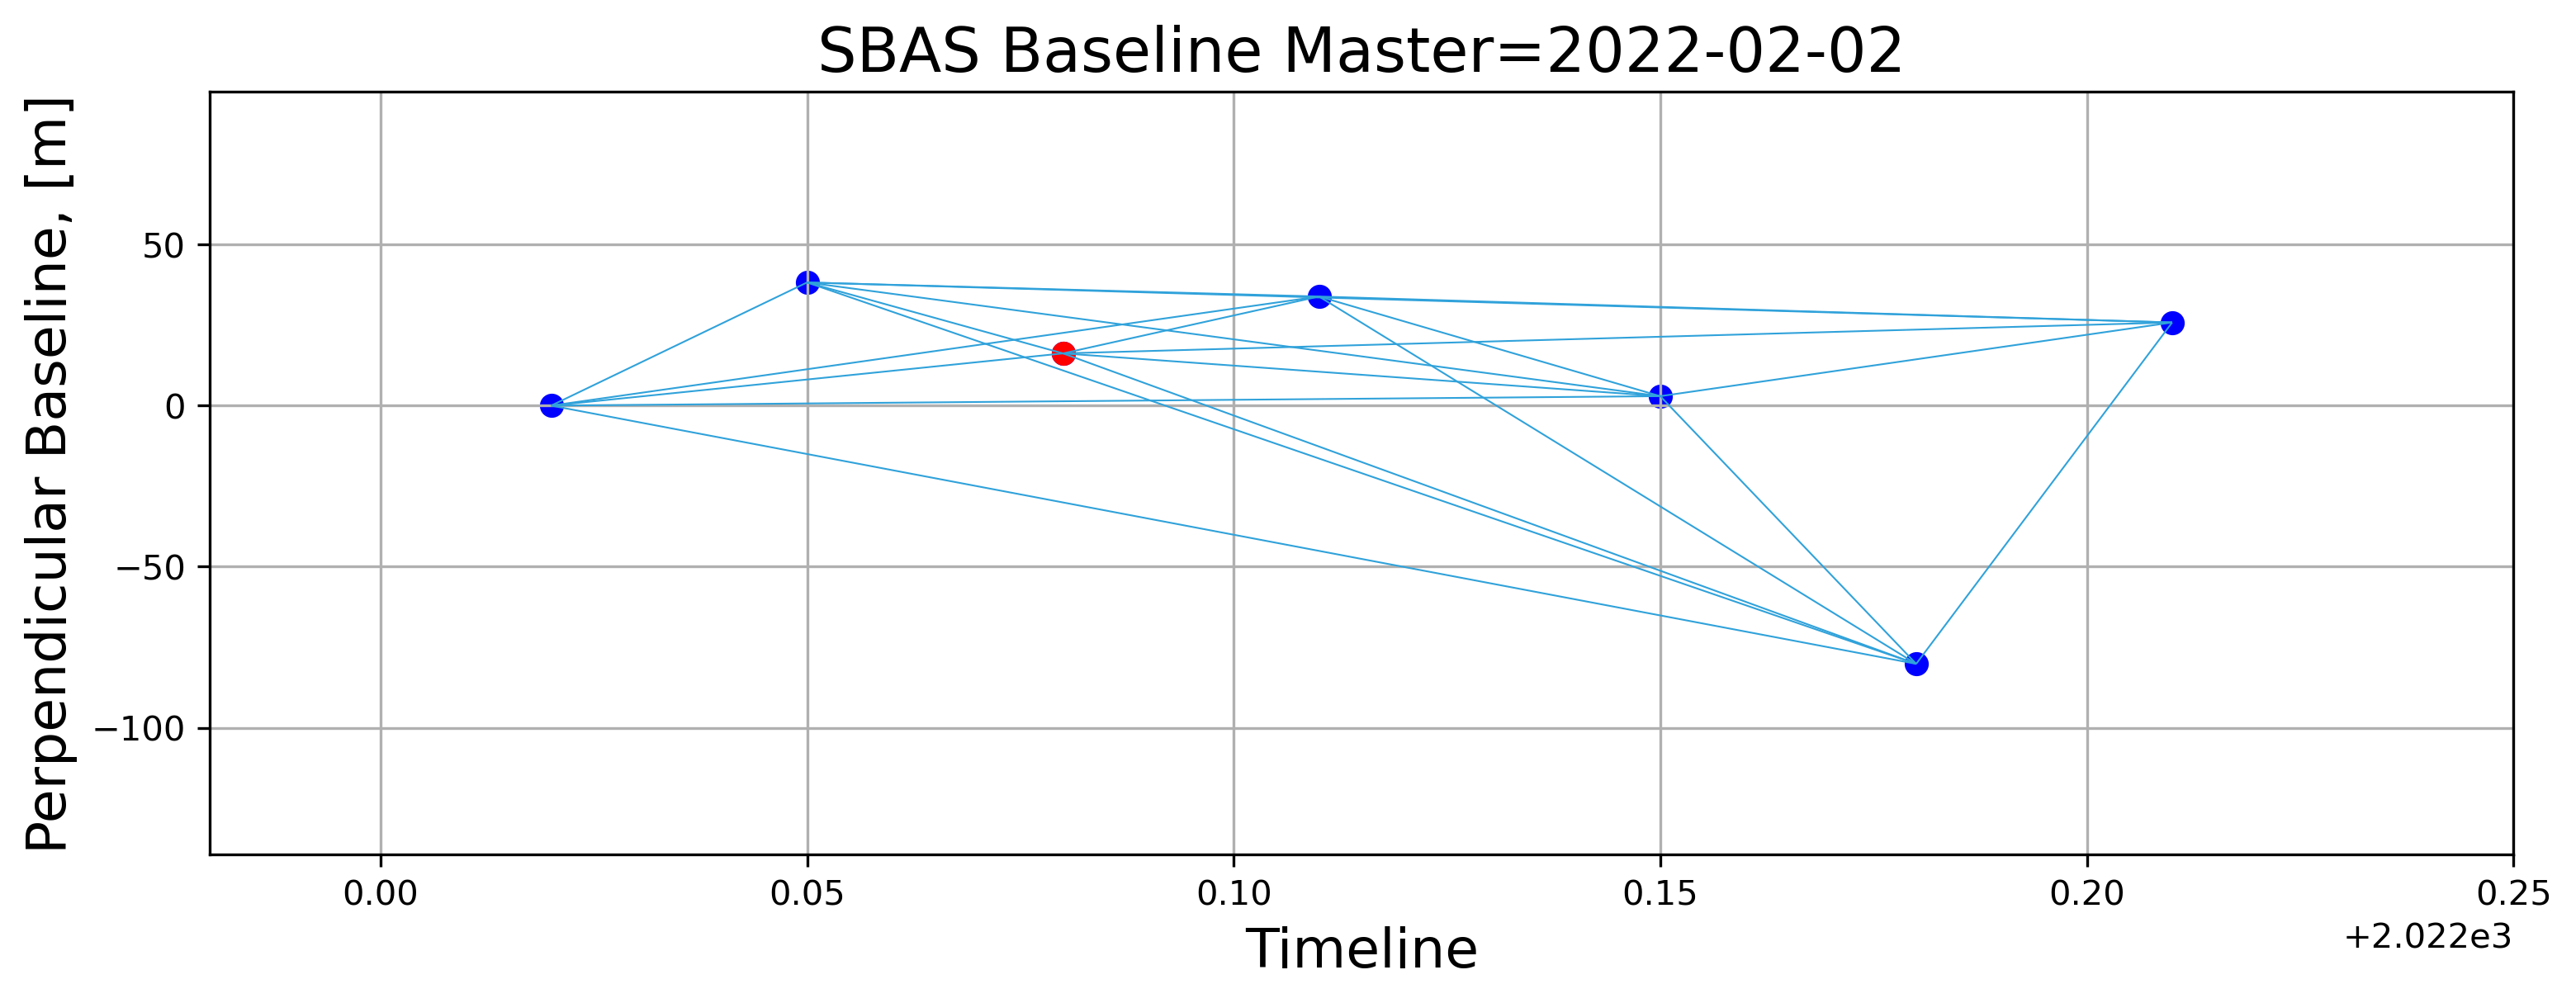

In [36]:
plt.figure(figsize=(12,4), dpi=300)
ax = plt.gca()

lines = [[(row.ref_timeline,row.ref_baseline),(row.rep_timeline,row.rep_baseline)]
         for row in baseline_pairs.itertuples()]
lc = matplotlib.collections.LineCollection(lines, colors='#30a2da', linewidths=0.5)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.5)
bs1 = baseline_pairs[['ref_timeline','ref_baseline','ref_date']].values
bs2 = baseline_pairs[['rep_timeline','rep_baseline','rep_date']].values
df = pd.DataFrame(np.concatenate([bs1, bs2]), columns=['timeline','baseline','date']).drop_duplicates()
plt.scatter(x=df.timeline, y=df.baseline, c='blue')
plt.scatter(x=df[df.date == master].timeline, y=df[df.date == master].baseline, c='red')
ax.set_xlim([baseline_pairs.ref_timeline.min()-0.04, baseline_pairs.rep_timeline.max()+0.04])
#for x,y,label in df.values:
#    plt.annotate(label, (x,y), textcoords="offset points", xytext=(35,3), ha='center',
#                 c='red' if label == master else 'black')
ax.set_xlabel('Timeline', fontsize=16)
ax.set_ylabel('Perpendicular Baseline, [m]', fontsize=16)
ax.set_title(f'SBAS Baseline Master={master}', fontsize=18)
plt.grid()
plt.show()

## Align Pairs of Images

In [37]:
sbas.stack_parallel(n_jobs=2)

Reference:   0%|          | 0/3 [00:00<?, ?it/s]

Aligning:   0%|          | 0/18 [00:00<?, ?it/s]

## DEM in Radar Coordinates

In [38]:
sbas.topo_ra_parallel()

Radar Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Analyze Transform Blocks:   0%|          | 0/299 [00:00<?, ?it/s]

Analyze Transform Blocks:   0%|          | 0/312 [00:00<?, ?it/s]

Analyze Transform Blocks:   0%|          | 0/264 [00:00<?, ?it/s]

Radar Topography Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [39]:
topo_ra = sbas.get_topo_ra()
# unify a single subswath processing and multiple ones
topo_ra = topo_ra if isinstance(topo_ra, list) else [topo_ra]

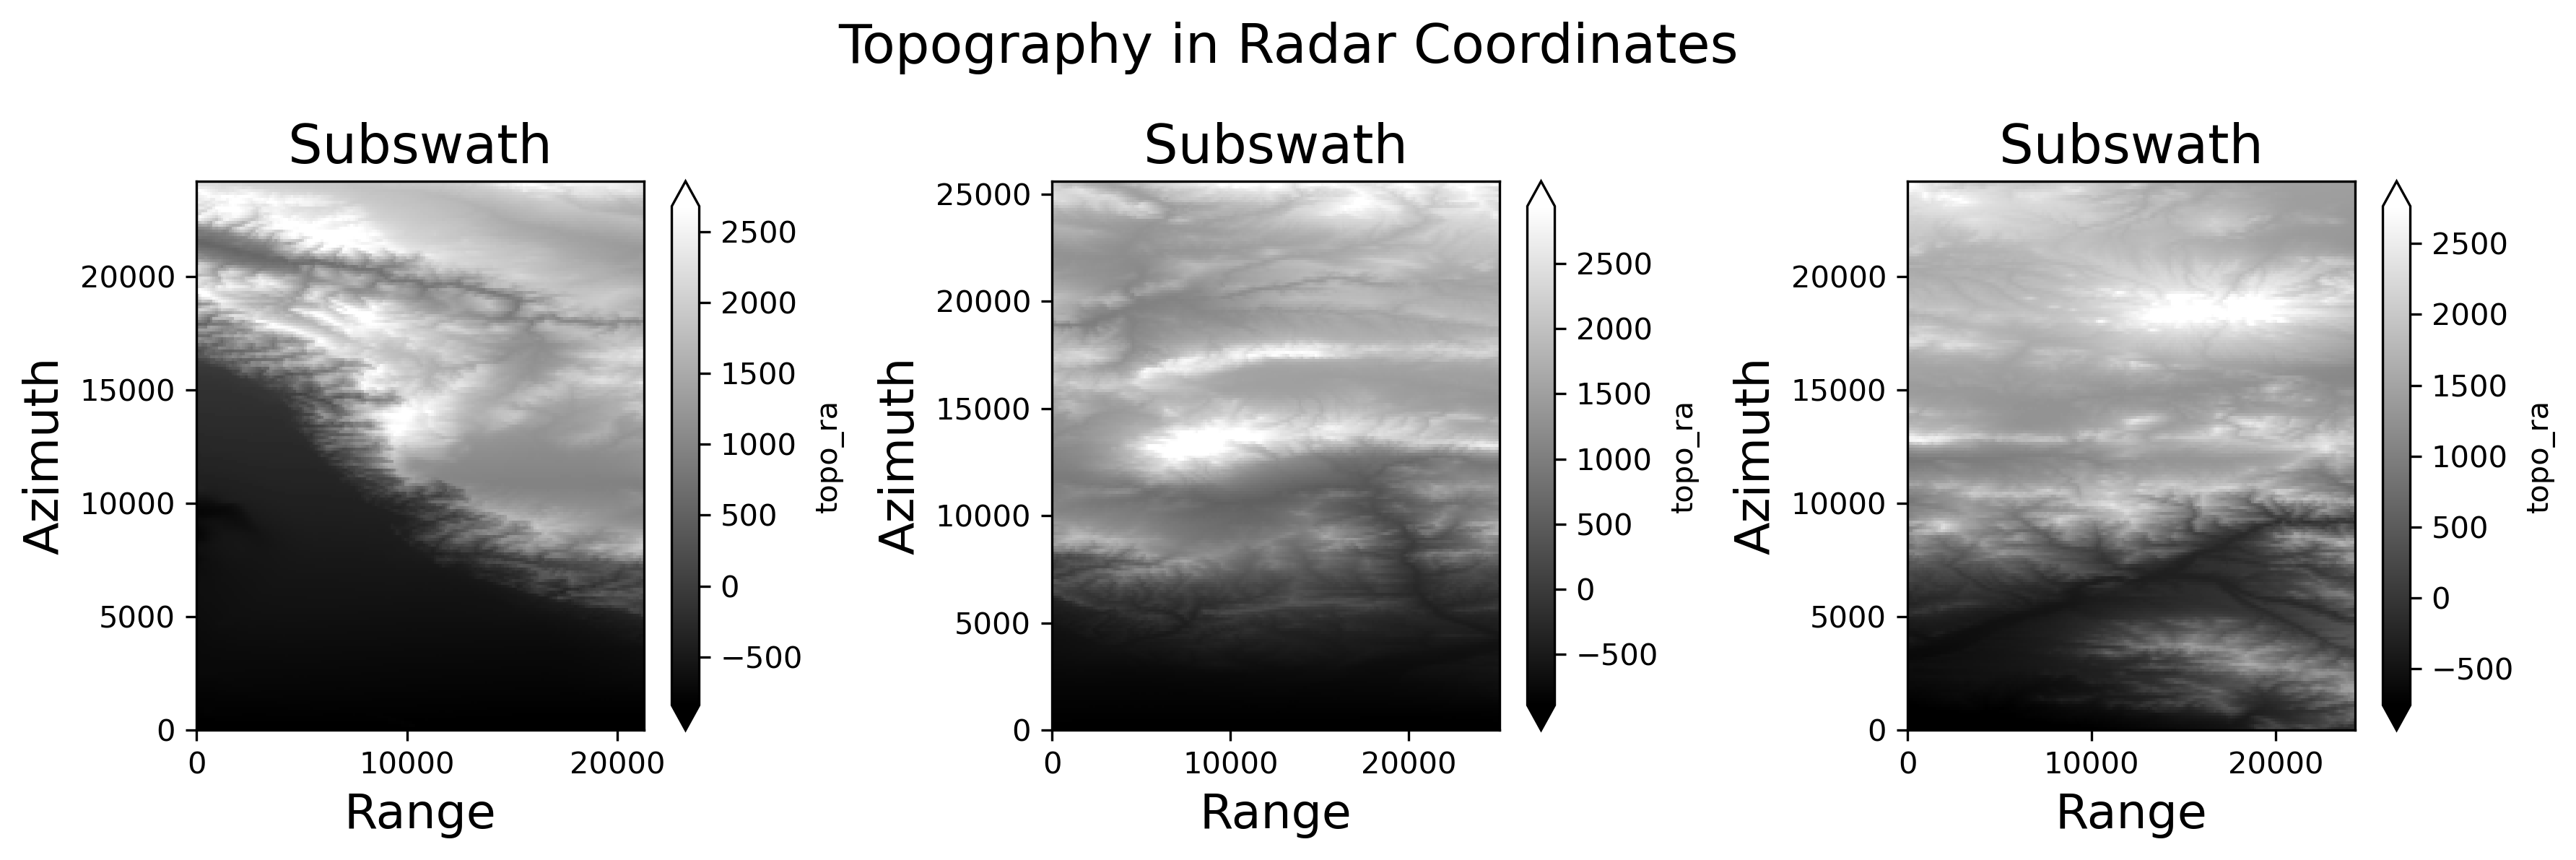

In [40]:
fig = plt.figure(figsize=(12,4), dpi=300)
subswaths = len(topo_ra)
for subswath in range(subswaths):
    ax = fig.add_subplot(1, subswaths, subswath + 1)
    zmin, zmax = np.nanquantile(topo_ra[subswath], [0.01, 0.99])
    topo_ra[subswath].coarsen({'x': 64, 'y': 64}, boundary='trim').mean()\
        .plot.imshow(cmap='gray', vmin=zmin, vmax=zmax, ax=ax)
    plt.xlabel('Range', fontsize=16)
    plt.ylabel('Azimuth', fontsize=16)
    plt.title('Subswath', fontsize=18)

plt.suptitle('Topography in Radar Coordinates', fontsize=18)
plt.tight_layout()
plt.show()

## Build Interferogram

In [41]:
pairs = baseline_pairs[['ref_date', 'rep_date']]
pairs

ref_date    rep_date
0   2022-01-09  2022-01-21
1   2022-01-09  2022-02-02
2   2022-01-09  2022-02-14
3   2022-01-09  2022-02-26
4   2022-01-09  2022-03-10
5   2022-01-21  2022-02-02
6   2022-01-21  2022-02-14
7   2022-01-21  2022-02-26
8   2022-01-21  2022-03-10
9   2022-01-21  2022-03-22
10  2022-02-02  2022-02-14
11  2022-02-02  2022-02-26
12  2022-02-02  2022-03-10
13  2022-02-02  2022-03-22
14  2022-02-14  2022-02-26
15  2022-02-14  2022-03-10
16  2022-02-14  2022-03-22
17  2022-02-26  2022-03-10
18  2022-02-26  2022-03-22
19  2022-03-10  2022-03-22

In [42]:
# miss optional "func" argument when post-processing is not required
decimator = sbas.pixel_decimator(resolution_meters=RESOLUTION, debug=True)

# default parameters: wavelength=200, psize=32, func=None (no postprocessing)
#, wavelength=200, func=decimator
sbas.intf_parallel(pairs, func=decimator, n_jobs=2)

DEBUG: average per subswaths ground pixel size in meters: y=13.966666666666667, x=15.0
DEBUG: decimator = lambda da: da


Interferograms:   0%|          | 0/60 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args)

KeyboardInterrupt: 

## Merge Subswaths (Optional)

In [ ]:
# use n_jobs=1 in case of "FileNotFoundError" error, for details see https://github.com/gmtsar/gmtsar/issues/458
sbas.merge_parallel(pairs, n_jobs=1)

In [ ]:
sbas.to_dataframe()

## Dump

Save directory WORKDIR with the saved state and close the notebook. Continue work later on the same or another host using SBAS.restore() command. As interferograms as unwrapped phases can be loaded using restored SBAS object.

In [ ]:
# dump current state into WORKDIR 
sbas.dump()
# restore the current state later of from other notebook to continue
# sbas = SBAS.restore(WORKDIR)

## Build Geocoding Matrices (Optional)

Source grid pixels can be translated to the target grid pixels very fast using the geocoding matrices.

In [ ]:
sbas.geocode_parallel(pairs)

## Load and Display Top 15 Interferograms

In case of "CancelledError exception" just re-execute the cell. It means the data loading requires long time and looks unresponsive and the execution is failed for this reason.

In [ ]:
# decimate to plot faster
phasefilts = sbas.open_grids(pairs[:15], 'phasefilt')\
    .coarsen({'x': 64, 'y': 64}, boundary='trim').mean()
phasefilts

In [ ]:
%%time

fg = phasefilts.plot.imshow(
    col='pair',
    col_wrap=5, size=4, aspect=1.2,
    vmin=-np.pi, vmax=np.pi, cmap='gist_rainbow_r'
)
fg.set_ticks(max_xticks=5, max_yticks=5, fontsize='medium')
fg.fig.suptitle('Top 15 Phase, [rad]', y=1.02, fontsize=36)
#plt.savefig(f'Phase, [rad].jpg', dpi=150, quality=95)
plt.show()

## Load and Display Top 15 Correlations

In case of "CancelledError exception" just re-execute the cell. It means the data loading requires long time and looks unresponsive and the execution is failed for this reason.

In [ ]:
# decimate to plot faster
corrs = sbas.open_grids(pairs[:15], 'corr')\
    .coarsen({'x': 64, 'y': 64}, boundary='trim').mean()
corrs

In [ ]:
%%time

fg = corrs.plot.imshow(
    col='pair',
    col_wrap=5, size=4, aspect=1.2,
    vmin=-0, vmax=0.8, cmap='gray'
)
fg.set_ticks(max_xticks=5, max_yticks=5, fontsize='medium')
fg.fig.suptitle('Top 15 Correlation', y=1.02, fontsize=36)
#plt.savefig(f'Correlation.jpg', dpi=150, quality=95)
plt.show()

## Backup Pre-Processed Data (cropped GeoTIFF, orbits, DEM grid, landmask)

Save the stitched and cropped scenes and downloaded DEM and orbit files to a new directory using `SBAS.backup(dir)` command and load the dataset later as `SBAS(dir, 'dir/DEM_WGS84.nc', basedir=WORKDIR)` Do not forgot to download the backup to use it later.

Note: that's required to do the full processing using backaped data but DATADIR is not required more. For the example: backup size for 2021 year ascending orbit is just 18 GB vs 240 GB raw Sentinel-1 unpacked scenes.

In [ ]:
if BACKUP is not None and DATADIR != BACKUP:
    print ('Create backup to use it for the next reproducible runs without the original scenes downloading')
    sbas.backup(BACKUP)

## Check and Export Area in Geographic Coordinates

Check if AOI is well covered by computed interferograms area. Low-coherence areas would be cropped on the next step (unwrapping).

To work effectivly on the large coherence grids stack aggregate all the grids (using max() function below) and geocode the single aggregated grid only.

In case of "CancelledError exception" just re-execute the cell. It means the data loading requires long time and looks unresponsive and the execution is failed for this reason.

In [ ]:
# use the original resolution for the export фтв вусшьфеув ещ здще
corr_stack_max_ll = sbas.intf_ra2ll(sbas.open_grids(pairs, 'corr').max(['pair']))
corr_stack_max_ll

In [ ]:
%%time

plt.figure(figsize=(12,4))
# decimate to plot faster
corr_stack_max_ll.coarsen({'lat': 32, 'lon': 32}, boundary='trim').mean().plot(cmap='gray')
plt.title('Stack Maximum Correlation', fontsize=18)
plt.show()

In [ ]:
filename = f'{WORKDIR}.corrstackmax.nc'
# drop the existing file first
!rm -fr {filename}
# show progress indicator for the long operation
from pygmtsar import tqdm_dask
# read all the correlation grids as 3D stack and calculate maximum value for every pixel
delayed = corr_stack_max_ll.to_netcdf(filename, engine=sbas.engine, compute=False)
tqdm_dask(dask.persist(delayed), desc='Saving Max Stack Coherency as NetCDF')

## Done

All the interferograms processed and unwrapped and project is dumped and can be restored later to continue the analysis. That's safer to create a new notebook for the post-processing because plotting a large timeseries requires a lot of RAM and the notebook can be out of RAM at any time.